# NLP Classification - Logistic Regression

In [32]:
import pandas as pd
import numpy as np

# Visualization library
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

## Statistical modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Data Aquisition

Dataset features:

reviewText: Text of the review<BR>
summary: Summary of the review<BR>
verified: Whether the purchase was verified (True or False)<BR>
time: UNIX timestamp for the review<BR>
rating: Rating of the review<BR>
log_votes: Logarithm-adjusted votes log(1+votes)<BR>

In [7]:
pwd

'/Users/lalithap/Desktop/Flatiron/git/my_github/isv-flatiron/deep_NLP/notebooks/NLP_cassification'

In [8]:
# Read training data
df = pd.read_csv('../../data/classify/AMAZON-REVIEW-DATA-CLASSIFICATION.csv')
df.head()

,reviewText,summary,verified,time,log_votes,isPositive
0,"PURCHASED FOR YOUNGSTER WHO\nINHERITED MY ""TOO...",IDEAL FOR BEGINNER!,True,1361836800,0.000000,1.0
1,unable to open or use,Two Stars,True,1452643200,0.000000,0.0
2,Waste of money!!! It wouldn't load to my system.,Dont buy it!,True,1433289600,0.000000,0.0
3,I attempted to install this OS on two differen...,I attempted to install this OS on two differen...,True,1518912000,0.000000,0.0
4,I've spent 14 fruitless hours over the past tw...,Do NOT Download.,True,1441929600,1.098612,0.0


##  EDA - Exploratory Data Analysis

In [9]:
print('Number of observations {} in the dataset. Number of features {}'.format(df.shape[0], df.shape[1]))

Number of observations 70000 in the dataset. Number of features 6


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  69989 non-null  object 
 1   summary     69986 non-null  object 
 2   verified    70000 non-null  bool   
 3   time        70000 non-null  int64  
 4   log_votes   70000 non-null  float64
 5   isPositive  70000 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 2.7+ MB


In [11]:
'''
    There are some null values in 'reviewText' & 'summary'
'''
if (df.isna().sum().sum() > 0 ):
    print("There are null values in the dataset")
else: print("There are NO null values in the dataset")

There are null values in the dataset


In [12]:
'''
Rows with null values in reviewText
'''
df[df["reviewText"].isnull()]

,reviewText,summary,verified,time,log_votes,isPositive
1002,NaN,Five Stars,True,1464393600,0.0,1.0
4489,NaN,Five Stars,True,1445990400,0.0,1.0
9295,NaN,Five Stars,True,1518652800,0.0,1.0
9532,NaN,NaN,True,1515369600,0.0,1.0
14518,NaN,Five Stars,True,1517184000,0.0,1.0
18173,NaN,Three Stars,True,1478822400,0.0,0.0
20042,NaN,Five Stars,False,1511308800,0.0,1.0
20561,NaN,Five Stars,True,1482364800,0.0,1.0
26304,NaN,Five Stars,True,1483660800,0.0,1.0
26915,NaN,NaN,True,1437004800,0.0,1.0


In [13]:
'''
Rows with null values in summary
'''
df[df["summary"].isnull()]


,reviewText,summary,verified,time,log_votes,isPositive
9532,NaN,NaN,True,1515369600,0.000000,1.0
10578,Fully satisfied,NaN,True,1428710400,0.000000,1.0
11449,I really like it!! A lot of repeat music thou...,NaN,True,1492473600,0.000000,1.0
16119,Awesome game really fun and it helped me learn...,NaN,True,1461628800,0.000000,1.0
24172,Love this program,NaN,True,1411084800,0.000000,1.0
26915,NaN,NaN,True,1437004800,0.000000,1.0
30305,I know little about computers. I wanted to be ...,NaN,True,1188345600,1.386294,1.0
39274,THIS IS A BIG JOKE.....I GOT IT IN THE MAIL A...,NaN,True,1418169600,0.000000,0.0
45530,"First of all, I want to say that the quality o...",NaN,True,1214524800,1.945910,1.0
54821,I know little about computers. I wanted to be ...,NaN,True,1188345600,0.000000,1.0


In [14]:
df.describe()

,time,log_votes,isPositive
count,7.000000e+04,70000.000000,70000.000000
mean,1.370112e+09,0.535257,0.624171
std,1.149986e+08,0.962677,0.484340
min,9.421920e+08,0.000000,0.000000
25%,1.322870e+09,0.000000,0.000000
50%,1.406160e+09,0.000000,1.000000
75%,1.448669e+09,1.098612,1.000000
max,1.538438e+09,7.110696,1.000000


In [15]:
'''
    target variable is isPositive
'''
df["isPositive"].value_counts()

1.0    43692
0.0    26308
Name: isPositive, dtype: int64

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


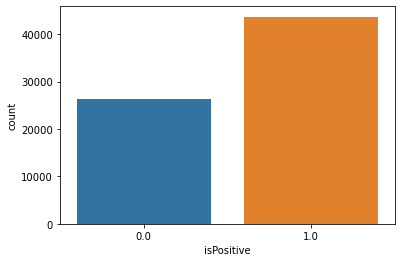

In [18]:
sns.countplot(df['isPositive']);

## Text Processing: Stop words removal and stemming 

In [51]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/lalithap/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lalithap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Preparation

In [19]:
# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "log_votes"]],
                                                  df["isPositive"],
                                                  test_size=0.12,
                                                  shuffle=True,
                                                  random_state=42
                                                 )

In [21]:
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

Processing the reviewText fields
Processing the summary fields


'''
    Process reviewText and summary fields
'''
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

## Data processing with pipeline

In [22]:
lst_num = ['time', 'log_votes']
lst_text = ['summary', 'reviewText']
model_features = lst_num + lst_text

In [27]:
# Setup preprocessing pipeline
num_pipeline = Pipeline([ ('num_scaler', MinMaxScaler())])
text0_pipeline = Pipeline([ ('text_vect_0', CountVectorizer(binary=True, max_features=50))])
text1_pipeline = Pipeline([ ('text_vect_1', CountVectorizer(binary=True, max_features=150))])

# build preprocessor pipeline
model_preprocessor = ColumnTransformer([
    ('numerical_pre', num_pipeline, lst_num),
    ('text_pre_0', text0_pipeline, lst_text[0]),
    ('text_pre_1', text1_pipeline, lst_text[1])
]) 

# build pipeline an the estimator(logistic_regression)
pipeline = Pipeline([
    ('data_preprocessing', model_preprocessor),
    ('logistic_regression', LogisticRegression(penalty = 'l2',
                              C = 0.1))
                    ])

In [28]:
# Visualize the pipeline
set_config(display='diagram')
pipeline
        

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression', LogisticRegression(C=0.1))])

## Run Logistic Regression model

In [30]:
# Train the logistic regresssion model
pipeline.fit(X_train[model_features], y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'log_votes']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('logistic_regression', LogisticRegression(C=0.1))])

## Test a Logistic Regression Classifier

In [33]:
# Use the fitted pipeline to make predictions on the validation dataset
val_predictions = pipeline.predict(X_val)
print(confusion_matrix(y_val.values, val_predictions))
print(classification_report(y_val.values, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val.values, val_predictions))

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


[[2379  706]
 [ 569 4746]]
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      3085
         1.0       0.87      0.89      0.88      5315

    accuracy                           0.85      8400
   macro avg       0.84      0.83      0.84      8400
weighted avg       0.85      0.85      0.85      8400

Accuracy (validation): 0.8482142857142857


## Probability Threshold

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/sit

Highest Accuracy on Validation: 0.8497619047619047 , Threshold for the highest Accuracy: 0.54


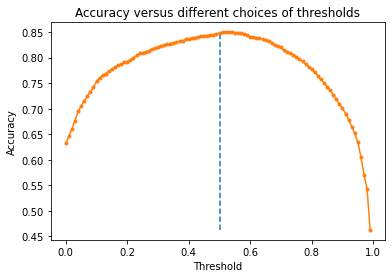

In [35]:
# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (pipeline.predict_proba(X_val)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/lalithap/anaconda3/envs/learn-env/lib/python3.8/sit

Highest Accuracy on Validation: 0.8497619047619047 , Threshold for the highest Accuracy: 0.54


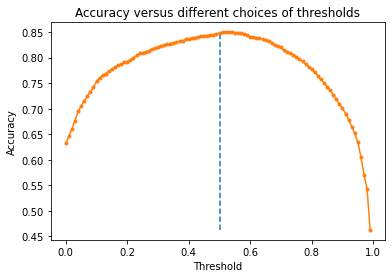

In [36]:
# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (pipeline.predict_proba(X_val)[:,1] >= t).astype(float)
    score = accuracy_score(y_val, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t
print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()